In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn import functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from prodigyopt import Prodigy
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Define the model
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, categorical_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, categorical_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

class Decoder(nn.Module):
    def __init__(self, categorical_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(categorical_dim, hidden_dim_2)
        self.fc2 = nn.Linear(hidden_dim_2, hidden_dim_1)
        self.fc3 = nn.Linear(hidden_dim_1, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # 确保输出在[0,1]范围内
        return x

def gumbel_softmax(logits, temperature):
    gs = F.gumbel_softmax(logits, tau=temperature, hard=False, dim=-1)
    return gs

class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return F.softmax(self.fc(x), dim=1)
    
def compute_kernel(x, y):
    x_size = x.shape[0]
    y_size = y.shape[0]
    dim = x.shape[1]
    tiled_x = x.view(x_size, 1, dim).repeat(1, y_size, 1)
    tiled_y = y.view(1, y_size, dim).repeat(x_size, 1, 1)
    return torch.exp(-torch.mean((tiled_x - tiled_y) ** 2, dim=2) / dim * 2.0)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return torch.mean(x_kernel) + torch.mean(y_kernel) - 2 * torch.mean(xy_kernel)



In [2]:
def train_and_plot(dataset_name, hidden_dim_1, hidden_dim_2, batch_size, epochs, initial_lr, temperature, final_temperature):
    # 加载数据
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
    if dataset_name == "MNIST":
        dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    elif dataset_name == "FashionMNIST":
        dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    elif dataset_name == "EMNIST":
        dataset = datasets.EMNIST('./data', train=True, download=True, transform=transform, split='balanced')
    dataset_img_size = dataset[0][0].shape[0]
    # get the number of classes
    classes = []
    for _, label in dataset:
        if label not in classes:
            classes.append(label)
    num_classes = len(classes)
    categorical_dim = num_classes
    input_dim = output_dim = dataset_img_size

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    annealing_rate = (temperature - final_temperature) / (epochs * len(dataloader))

    # 创建模型
    encoder = Encoder(input_dim, hidden_dim_1, hidden_dim_2, categorical_dim)
    decoder = Decoder(categorical_dim, hidden_dim_1, hidden_dim_2, output_dim)
    classifier = Classifier(categorical_dim, num_classes)

    # Optimizer & Scheduler
    # optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=initial_lr)
    # optimizer = Prodigy(list(encoder.parameters()) + list(decoder.parameters()), lr=initial_lr)
    # optimizer = optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=initial_lr)
    optimizer = optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()) + list(classifier.parameters()), lr=initial_lr)

    scheduler = CosineAnnealingLR(optimizer, T_max=(len(dataloader) * epochs), eta_min=1e-5)

    # initialize the loss lists
    recon_losses = []
    kl_losses = []
    mmd_losses = []
    total_losses = []
    lr_list = []
    temperature_list = []

    # initialize the progress bar
    progress_bar = tqdm(total=(len(dataloader) * epochs), desc="Training Progress")

    # train the model
    for epoch in range(epochs):
        for batch in dataloader:
            x, labels_in_batch = batch
            x = x.view(-1, input_dim)  # 确保x的形状
            logits = encoder(x)
            z = gumbel_softmax(logits, temperature)
            classifier_output = classifier(logits)
            x_recon = decoder(z)

            # calculate the losses
            try:
                recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / x.shape[0]
            except Exception as e:
                # print(e)
                # print('------------------ Error ------------------')
                # print(f'x_recon: {x_recon}, \nx: {x}, \nx_recon.shape: {x_recon.shape}, x.shape: {x.shape}\n')
                # print(f'logits: {logits}, \nz: {z}, \nlogits.shape: {logits.shape}, z.shape: {z.shape}\n')
                # print('------------------ Error ------------------')
                break
            # KL散度损失 - 1
            log_softmax_logits = F.log_softmax(logits, dim=-1)
            uniform_distribution = torch.ones_like(log_softmax_logits) * (1.0 / categorical_dim)
            one_hot_labels = torch.zeros_like(log_softmax_logits).scatter_(1, labels_in_batch.unsqueeze(1), 1.0)
            kl_loss = F.kl_div(log_softmax_logits, one_hot_labels, reduction='sum') * 1.0
            # # KL散度损失 - 2
            # logits_y = logits
            # q_y = F.softmax(logits_y, dim=-1)
            # log_q_y = torch.log(q_y + 1e-20)
            # kl_tmp = q_y * (log_q_y - torch.log(torch.tensor(1.0 / categorical_dim)))
            # KL = torch.sum(kl_tmp, dim=-1)
            # kl_loss = torch.sum(KL) # Sum over the batch size
            # # KL散度损失 - 3 正态分布
            # mu = logits.mean()
            # var = logits.var()
            # std = torch.sqrt(var + 1e-10)

            # # 对于标准正态分布
            # mu_target = torch.zeros_like(mu)
            # std_target = torch.ones_like(std)

            # # KL divergence
            # kl_div = 0.5 * (var + mu**2 - 1 - torch.log(var + 1e-10))
            # kl_loss = torch.sum(kl_div)


            true_samples = torch.randn(x.size(0), categorical_dim) # You might need to adjust this line if your latent dimension is different.
            mmd_loss = compute_mmd(true_samples, z.detach())


            loss = recon_loss + kl_loss + mmd_loss
            # 尝试了三种损失合体的方式，最后RI=0.16，其中KL损失是计算logits的平均值和方差，并与标准正态分布进行比较

            # classification_loss = F.cross_entropy(classifier_output, labels_in_batch)
            # loss += classification_loss

            # gradient descent & backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # log the losses
            recon_losses.append(recon_loss.item())
            kl_losses.append(kl_loss.item())
            # mmd_losses.append(mmd_loss.item())
            total_losses.append(loss.item())
            lr_list.append(scheduler.get_last_lr()[0])
            temperature_list.append(temperature)

            # update the progress bar
            # , MMD Loss: {mmd_loss.item():.7f}
            progress_bar.set_description(f'Epoch: {epoch+1}/{epochs} | Re.Loss: {recon_loss.item():.7f}, KL.Loss: {kl_loss.item():.7f} | Lr: {scheduler.get_last_lr()[0]:.7f} Temp: {temperature:.7f}', refresh=True)
            progress_bar.update(1)

            scheduler.step()  # update the learning rate
            temperature -= annealing_rate # update the temperature
            temperature = max(temperature, final_temperature)  # make sure the temperature is not lower than the minimum value

        # scheduler.step()  
        # temperature -= annealing_rate 
        # temperature = max(temperature, final_temperature)  

    progress_bar.close()
    final_loss = total_losses[-1]

    # plot the losses curve
    plt.plot(recon_losses, label='Reconstruction Loss')
    plt.plot(kl_losses, label='KL Divergence Loss')
    plt.plot(total_losses, label='Total Loss')
    # plt.plot(mmd_losses, label='MMD Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # plot the lr curve
    plt.plot(lr_list, label='lr')
    plt.show()

    # plot the temperature curve
    plt.plot(temperature_list, label='Temperature')
    plt.show()

    rand_index = evaluate(encoder, dataset, num_classes, use_gumbel_softmax=True, temperature=final_temperature)

    return dataset, encoder, decoder, final_loss


In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(encoder, dataset, num_clusters, use_gumbel_softmax=False, temperature=1.0):
    # 1. 使用Encoder对数据集进行编码
    encoded_data = []
    true_labels = []
    for data, label in dataset:
        encoded_output = encoder(data.view(-1).unsqueeze(0))
        if use_gumbel_softmax:
            encoded_output = gumbel_softmax(encoded_output, temperature)
        encoded_data.append(encoded_output.detach().numpy())
        true_labels.append(label)
    encoded_data = np.array(encoded_data).squeeze()
    true_labels = np.array(true_labels)
    
    # 2. 使用KMeans进行聚类
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(encoded_data)
    cluster_assignments = kmeans.labels_
    
    # 3. 计算ARI得分
    ari_score = adjusted_rand_score(true_labels, cluster_assignments)
    print(f"Adjusted Rand Index: {ari_score:.4f}")
    
    # 4. 计算混淆矩阵并绘制
    cm = confusion_matrix(true_labels, cluster_assignments)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    return ari_score

In [4]:
import random

def visualize_images(images, num_classes, title):
    fig, axes = plt.subplots(1, num_classes, figsize=(num_classes, 1))
    for i in range(num_classes):
        axes[i].imshow(images[i][0], cmap='gray')
        axes[i].axis('off')
    # plt.subplots_adjust(wspace=0.2, hspace=0.8)
    plt.suptitle(title)
    plt.show()

def sample_and_reconstruct(dataset, encoder, decoder, input_dim, num_classes, temperature):
    samples_per_class = 1
    original_images = [[] for _ in range(num_classes)]
    reconstructed_images = [[] for _ in range(num_classes)]
    selected_classes = [False] * num_classes
    
    with torch.no_grad():
        for x, y in random.sample(list(dataset), len(dataset)): # Shuffle dataset
            if all(selected_classes):
                break
            if selected_classes[y]:
                continue
            x = x.view(-1, input_dim)
            logits = encoder(x)
            z = gumbel_softmax(logits, temperature)
            x_recon = decoder(z)
            original_images[y].append(x.view(28, 28).numpy())
            reconstructed_images[y].append(x_recon.view(28, 28).numpy())
            selected_classes[y] = True

    visualize_images(original_images, num_classes, 'Original Images')
    visualize_images(reconstructed_images, num_classes, 'Reconstructed Images')



In [5]:
# # Reconstruction from dataset
# samples_per_class = 10
# original_images = [[] for _ in range(num_classes)]
# reconstructed_images = [[] for _ in range(num_classes)]

# with torch.no_grad():
#     for x, y in dataset:
#         if all(len(images) >= samples_per_class for images in original_images):
#             break
#         x = x.view(-1, input_dim)
#         logits = encoder(x)
#         z = gumbel_softmax(logits, temperature)
#         x_recon = decoder(z)
#         original_images[y].append(x.view(28, 28).numpy())
#         reconstructed_images[y].append(x_recon.view(28, 28).numpy())

# fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(10, 10))
# for i in range(num_classes):
#     for j in range(samples_per_class):
#         axes[i, j].imshow(original_images[i][j], cmap='gray')
#         axes[i, j].axis('off')
# plt.suptitle('Original Images')
# plt.show()

# fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(10, 10))
# for i in range(num_classes):
#     for j in range(samples_per_class):
#         axes[i, j].imshow(reconstructed_images[i][j], cmap='gray')
#         axes[i, j].axis('off')
# plt.suptitle('Reconstructed Images')
# plt.show()

In [6]:
# Generate from latent vector
# categorical_dim = 10
# input_dim = 28 * 28
# temperature = 0.5

def generate_from_latent(dataset, encoder, decoder, categorical_dim, temperature):
    # init
    latent_sums = torch.zeros(categorical_dim, categorical_dim)
    class_counts = torch.zeros(categorical_dim, dtype=torch.int)

    # calculate the sum of latent vectors for each class
    with torch.no_grad():
        for img, label in dataset:
            img = img.view(-1, input_dim)
            logits = encoder(img)
            z = gumbel_softmax(logits, temperature).squeeze()
            latent_sums[label] += z
            class_counts[label] += 1

    # calculate the average latent vector for each class
    avg_latent_vector = latent_sums / class_counts[:, None]

    fig, axes = plt.subplots(1, categorical_dim, figsize=(categorical_dim, 1))

    # plot for each class
    for i in range(categorical_dim):
        generated_img = decoder(avg_latent_vector[i])
        generated_img = generated_img.view(28, 28).detach().cpu().numpy()  # 转换为numpy数组
        ax = axes[i]
        ax.imshow(generated_img, cmap='gray')
        ax.set_title(f'Class {i}')
        ax.axis('off')

    # apply transformations to EMNIST images
    if dataset_name == 'EMNIST':
        from scipy.ndimage import rotate
        plt.close(fig)  # 关闭原始图像
        rows = 5
        cols = 10
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        # fig.subplots_adjust(hspace=0.2, wspace=0.2)  # 调整子图间的间距
        fig.suptitle('Generated EMNIST Images (rotated and flipped)')

        for i in range(categorical_dim):
            row = i // cols
            col = i % cols
            generated_img = decoder(avg_latent_vector[i])
            generated_img = generated_img.view(28, 28).detach().cpu().numpy()
            generated_img = rotate(generated_img, -90)  # 逆时针旋转90度
            generated_img = np.fliplr(generated_img)  # 水平镜像
            ax = axes[row, col]
            ax.imshow(generated_img, cmap='gray')
            ax.set_title(f'Class {i}')
            ax.axis('off')
        # 隐藏多余的子图
        for i in range(categorical_dim, rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis('off')
        fig.tight_layout()

    plt.show()
# # init
# latent_sums = torch.zeros(categorical_dim, categorical_dim)
# class_counts = torch.zeros(categorical_dim, dtype=torch.int)

# # calculate the sum of latent vectors for each class
# with torch.no_grad():
#     for img, label in dataset:
#         img = img.view(-1, input_dim)
#         logits = encoder(img)
#         z = gumbel_softmax(logits, temperature).squeeze()
#         latent_sums[label] += z
#         class_counts[label] += 1

# # calculate the average latent vector for each class
# avg_latent_vector = latent_sums / class_counts[:, None]

# fig, axes = plt.subplots(1, categorical_dim, figsize=(categorical_dim, 1))

# # plot for each class
# for i in range(categorical_dim):
#     generated_img = decoder(avg_latent_vector[i])
#     generated_img = generated_img.view(28, 28).detach().cpu().numpy()  # 转换为numpy数组
#     ax = axes[i]
#     ax.imshow(generated_img, cmap='gray')
#     ax.set_title(f'Class {i}')
#     ax.axis('off')

# # apply transformations to EMNIST images
# if dataset_name == 'EMNIST':
#     from scipy.ndimage import rotate
#     plt.close(fig)  # 关闭原始图像
#     rows = 5
#     cols = 10
#     fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
#     # fig.subplots_adjust(hspace=0.2, wspace=0.2)  # 调整子图间的间距
#     fig.suptitle('Generated EMNIST Images (rotated and flipped)')

#     for i in range(categorical_dim):
#         row = i // cols
#         col = i % cols
#         generated_img = decoder(avg_latent_vector[i])
#         generated_img = generated_img.view(28, 28).detach().cpu().numpy()
#         generated_img = rotate(generated_img, -90)  # 逆时针旋转90度
#         generated_img = np.fliplr(generated_img)  # 水平镜像
#         ax = axes[row, col]
#         ax.imshow(generated_img, cmap='gray')
#         ax.set_title(f'Class {i}')
#         ax.axis('off')
#     # 隐藏多余的子图
#     for i in range(categorical_dim, rows * cols):
#         row = i // cols
#         col = i % cols
#         axes[row, col].axis('off')
#     fig.tight_layout()

# plt.show()


In [7]:
from sklearn.manifold import TSNE
import numpy as np

def visualize_latent(dataset_name, encoder, num_classes=10, temperature=1.0):
    # init
    latent_vectors = torch.empty(0, categorical_dim)
    Y = torch.empty(0, dtype=torch.long)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # send dataset to encoder
    with torch.no_grad():
        for x, y in dataloader:
            x = x.view(-1, input_dim)
            logits = encoder(x)
            z = gumbel_softmax(logits, temperature)
            latent_vectors = torch.cat([latent_vectors, z])
            Y = torch.cat([Y, y])

    # convert latent vectors to numpy arrays
    latent_vectors = latent_vectors.cpu().numpy()
    Y = Y.cpu().numpy()

    # run t-SNE on latent vectors to get 2D embedding
    tsne = TSNE(n_components=2)
    latent_vectors_2d = tsne.fit_transform(latent_vectors)

    # plot 2D embedding
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=Y, cmap='tab10')
    if dataset_name == 'EMNIST':
        scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=Y, cmap='tab20')
    plt.colorbar(scatter, label='Class Labels')
    for i in range(num_classes):
        centroid = np.mean(latent_vectors_2d[Y == i], axis=0)
        plt.text(centroid[0], centroid[1], str(i), color='black', fontsize=12, fontweight='bold', ha='center', va='center')
    plt.show()

    # cm
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    # find the most likely label for each test input
    predicted_labels = latent_vectors.argmax(axis=1)

    # calculate the confusion matrix
    cm = confusion_matrix(Y, predicted_labels)

    # plot the confusion matrix
    plt.figure(figsize=(10, 8))
    if dataset_name == 'EMNIST':
        plt.figure(figsize=(50, 40))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # calculate accuracy
    from sklearn.metrics import adjusted_rand_score
    rand_index = adjusted_rand_score(Y, predicted_labels)
    print("Rand index: ", rand_index)

# # init
# latent_vectors = torch.empty(0, categorical_dim)
# Y = torch.empty(0, dtype=torch.long)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# # send dataset to encoder
# with torch.no_grad():
#     for x, y in dataloader:
#         x = x.view(-1, input_dim)
#         logits = encoder(x)
#         z = gumbel_softmax(logits, temperature)
#         latent_vectors = torch.cat([latent_vectors, z])
#         Y = torch.cat([Y, y])

# # convert latent vectors to numpy arrays
# latent_vectors = latent_vectors.cpu().numpy()
# Y = Y.cpu().numpy()

# # run t-SNE on latent vectors to get 2D embedding
# tsne = TSNE(n_components=2)
# latent_vectors_2d = tsne.fit_transform(latent_vectors)

# # plot 2D embedding
# plt.figure(figsize=(8, 8))
# scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=Y, cmap='tab10')
# if dataset_name == 'EMNIST':
#     scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=Y, cmap='tab20')
# plt.colorbar(scatter, label='Class Labels')
# for i in range(num_classes):
#     centroid = np.mean(latent_vectors_2d[Y == i], axis=0)
#     plt.text(centroid[0], centroid[1], str(i), color='black', fontsize=12, fontweight='bold', ha='center', va='center')
# plt.show()


In [8]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# # find the most likely label for each test input
# predicted_labels = latent_vectors.argmax(axis=1)

# # calculate the confusion matrix
# cm = confusion_matrix(Y, predicted_labels)

# # plot the confusion matrix
# plt.figure(figsize=(10, 8))
# if dataset_name == 'EMNIST':
#     plt.figure(figsize=(50, 40))
# sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()


In [9]:
# # Rand-index
# from sklearn.metrics import adjusted_rand_score
# rand_index = adjusted_rand_score(Y, predicted_labels)
# print("Rand index: ", rand_index)

Epoch: 10/10 | Re.Loss: 164.6030731, KL.Loss: 6.6446972 | Lr: 0.0000100 Temp: 0.5000083: 100%|██████████| 60000/60000 [14:05<00:00, 70.93it/s] 


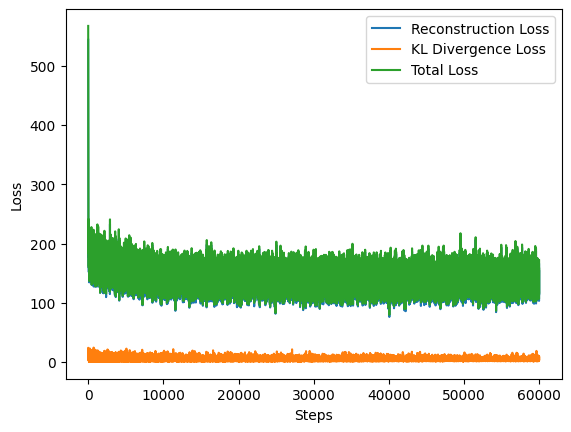

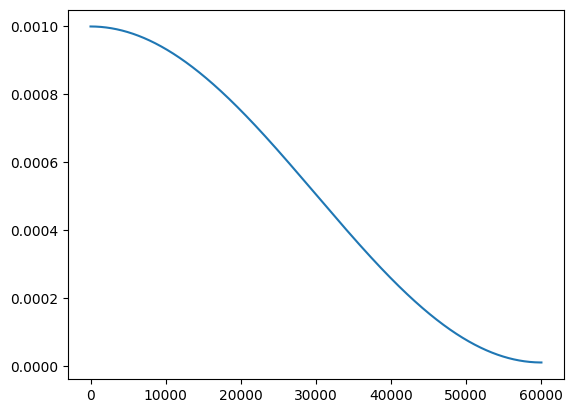

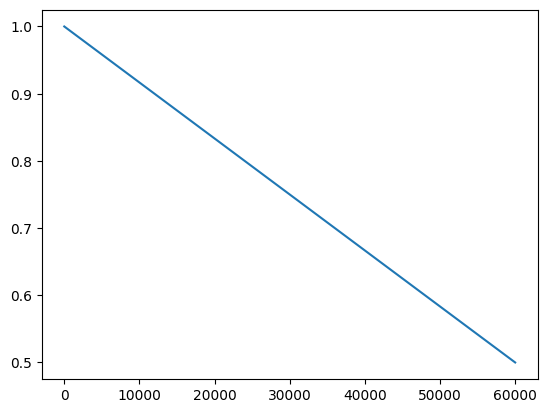

/Users/YUAN/opt/anaconda3/envs/myCVAE/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/YUAN/opt/anaconda3/envs/myCVAE/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Adjusted Rand Index: 0.4973


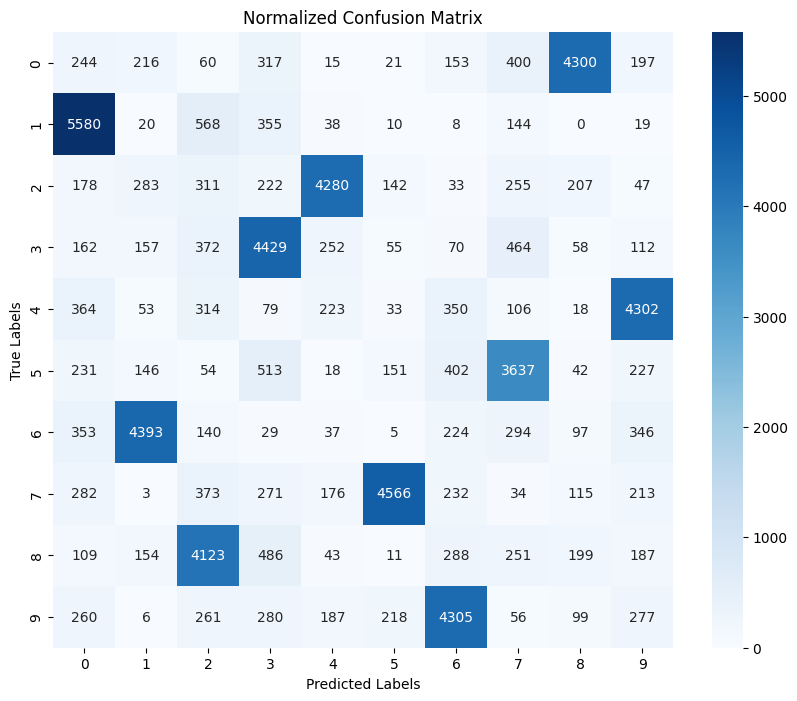

In [10]:
dataset_name = 'MNIST'
# hidden_dim_1 = 512
# hidden_dim_2 = 256
# batch_size = 32
# epochs = 64
# initial_lr = 1e-3
# temperature = 1.0
# final_temperature = 0.3

# hidden_dim_1 = 395
# hidden_dim_2 = 87
# batch_size = 229
# epochs = 108
# initial_lr = 0.008221946643391686
# temperature = 1.8602898465279396
# final_temperature = 0.9793508307172389
# beta = / batch_size * 29.843531299928905

# hidden_dim_1 = 425
# hidden_dim_2 = 500
# batch_size = 56
# epochs = 360
# initial_lr = 0.006023831168192716
# temperature = 1.4426243165789046
# final_temperature = 1.479644293752712

# Trial 57: 
# Hidden Dim 1: 940
# Hidden Dim 2: 363
# Batch Size: 17
# Epochs: 306
# Initial LR: 0.0007097821685505025
# Temperature: 0.7979487217875562
# Final Temperature: 1.2619637882684076
# Beta: 18.833685199272043
# Final Loss: 74.27774047851562

# Pretty good one(with labels):
# hidden_dim_1 = 940
# hidden_dim_2 = 363
# batch_size = 17
# epochs = 300
# initial_lr = 0.0007097821685505025
# temperature = 0.7979487217875562
# final_temperature = 1.2619637882684076

# temp 1.2 -> 0.2 RI: 0.28 Re.Loss: 173.2182312, KL.Loss: 13.0501108 with one-hot
hidden_dim_1 = 996
hidden_dim_2 = 360
batch_size = 10
epochs = 30
initial_lr = 0.001
temperature = 1.0
final_temperature = 0.5

dataset, encoder, decoder, final_loss = train_and_plot(dataset_name, hidden_dim_1, hidden_dim_2, batch_size, epochs, initial_lr, temperature, final_temperature)

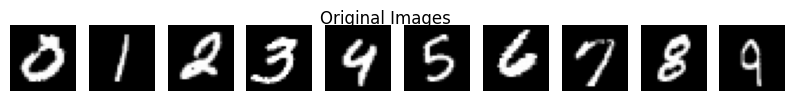

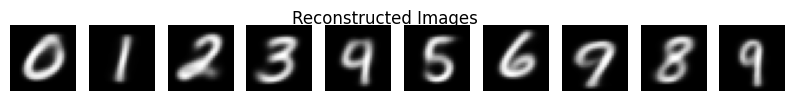

In [11]:
sample_and_reconstruct(dataset, encoder, decoder, input_dim=28*28, num_classes=10, temperature=final_temperature)

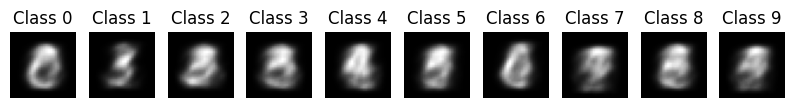

In [12]:
categorical_dim = 10
input_dim = 28 * 28
temperature = 0.5
generate_from_latent(dataset, encoder, decoder, categorical_dim=10, temperature=final_temperature)

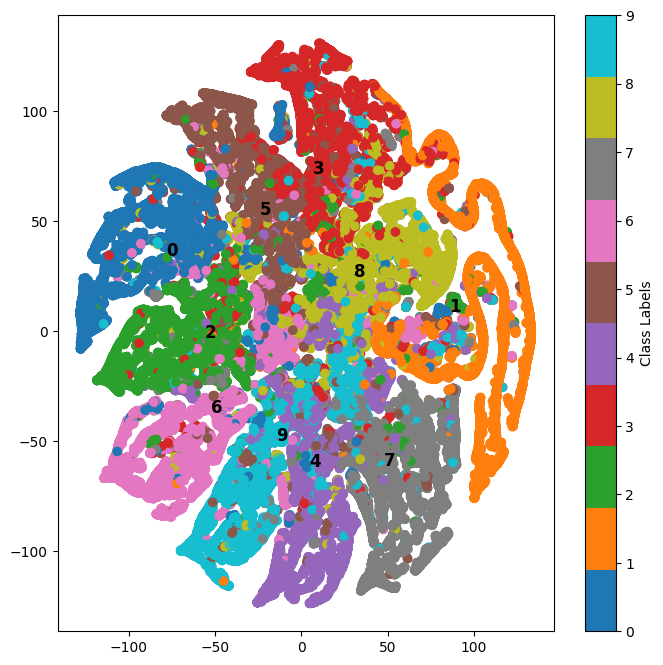

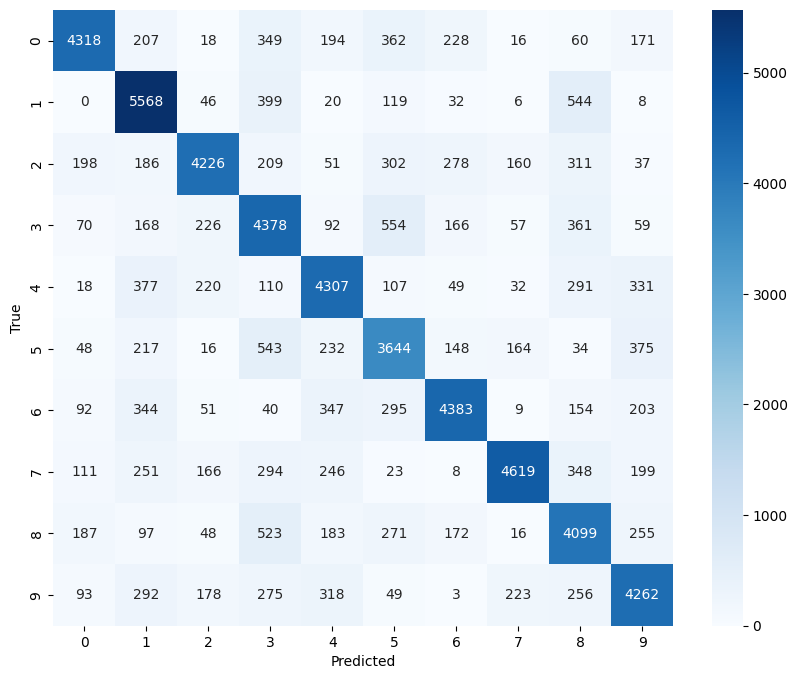

Rand index:  0.4948475007191159


In [13]:
visualize_latent(dataset_name, encoder, num_classes=10, temperature=1.0)

Epoch: 10/10 | Re.Loss: 279.3151245, KL.Loss: 4.0728092 | Lr: 0.0000339 Temp: 0.5000000:  90%|█████████ | 54040/60000 [12:24<01:22, 72.60it/s] 


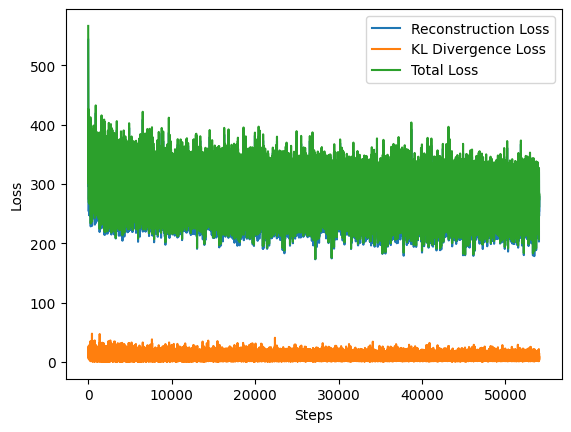

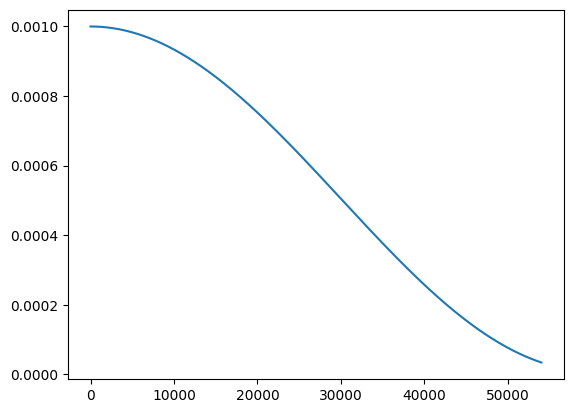

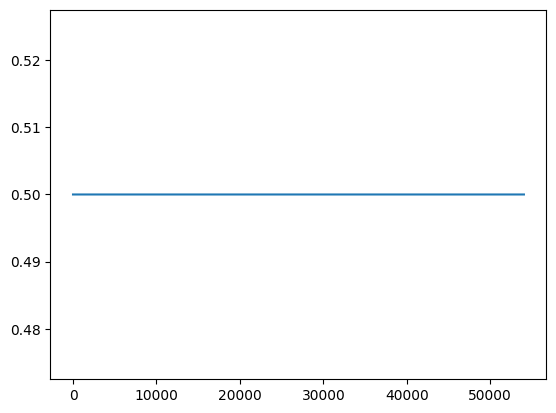

/Users/YUAN/opt/anaconda3/envs/myCVAE/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.4327


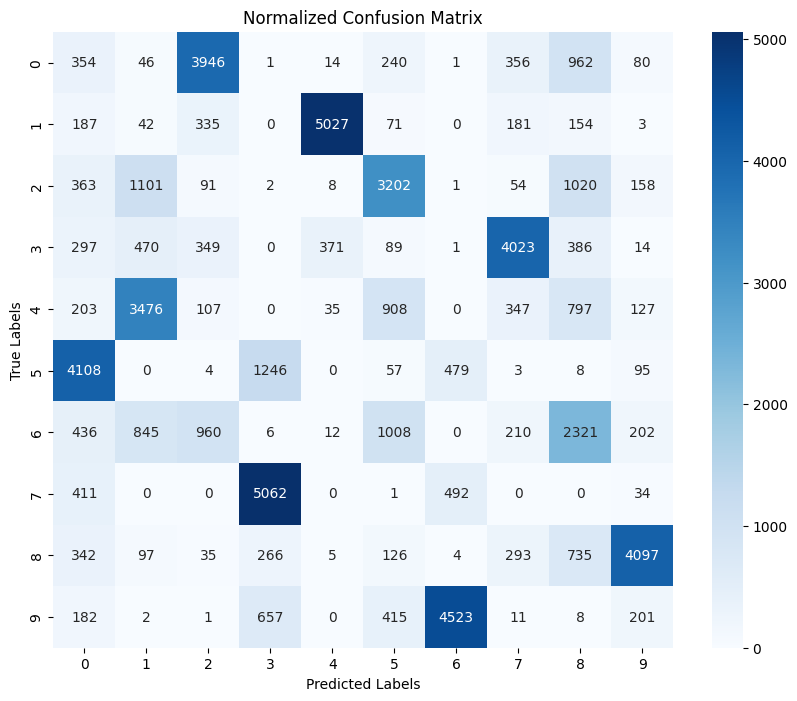

In [14]:
# Running on Fashion MNIST dataset
dataset_name = 'FashionMNIST'
# hidden_dim_1 = 512
# hidden_dim_2 = 256
# batch_size = 32
# epochs = 32
# initial_lr = 1e-3
# temperature = 1.0
# final_temperature = 0.3

dataset, encoder, decoder, final_loss = train_and_plot(dataset_name, hidden_dim_1, hidden_dim_2, batch_size, epochs, initial_lr, temperature, final_temperature)

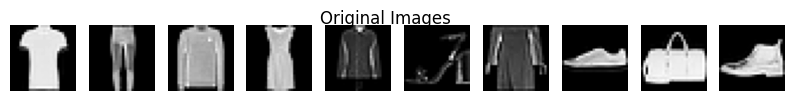

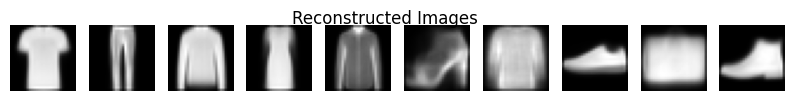

In [15]:
sample_and_reconstruct(dataset, encoder, decoder, input_dim=28*28, num_classes=10, temperature=final_temperature)

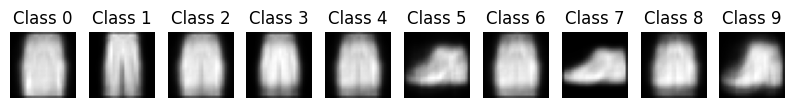

In [16]:
generate_from_latent(dataset, encoder, decoder, categorical_dim=10, temperature=final_temperature)

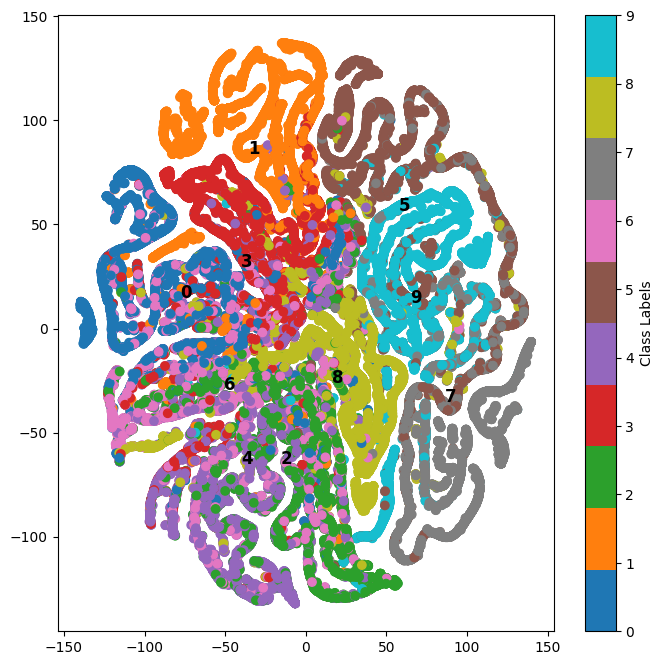

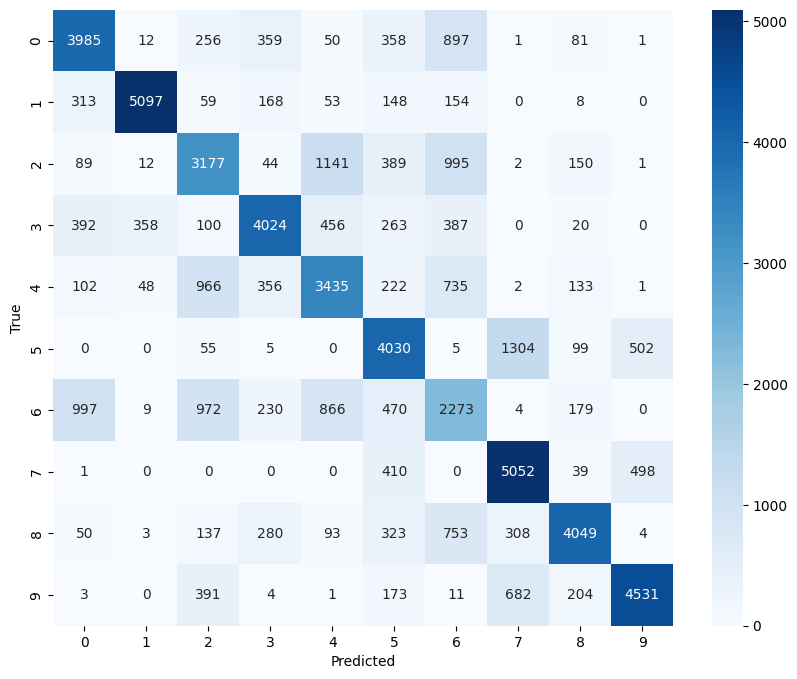

Rand index:  0.4312610554046879


In [17]:
visualize_latent(dataset_name, encoder, num_classes=10, temperature=final_temperature)

Epoch: 30/30 | Re.Loss: 175.5389099, KL.Loss: 5.8963656 | Lr: 0.0000140 Temp: 0.5000000:  96%|█████████▌| 324771/338400 [1:15:39<03:10, 71.54it/s] 


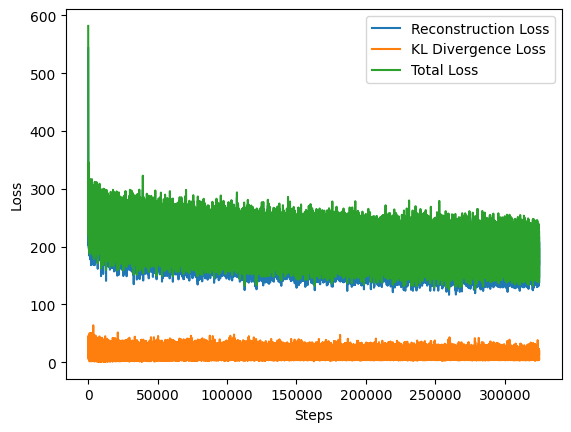

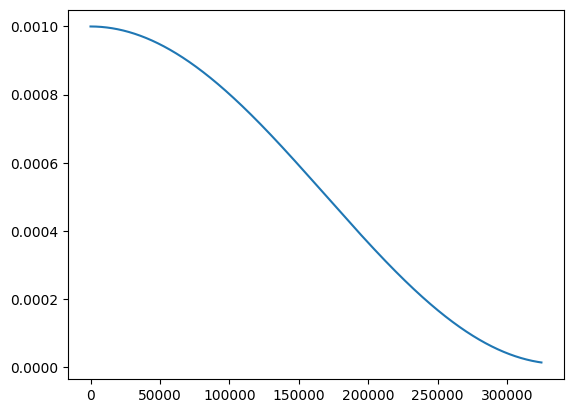

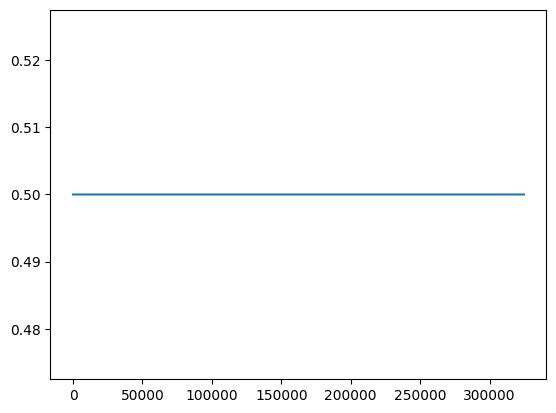

/Users/YUAN/opt/anaconda3/envs/myCVAE/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.2469


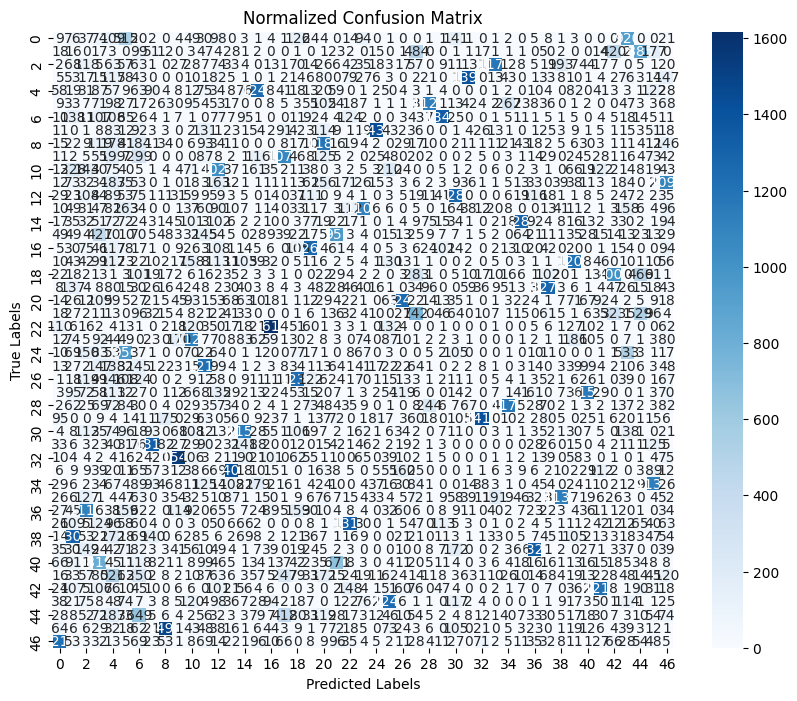

In [22]:
# Running on EMNIST dataset
dataset_name = 'EMNIST'
# hidden_dim_1 = 512
# hidden_dim_2 = 256
# batch_size = 32
# epochs = 32
# initial_lr = 1e-3
# temperature = 1.0
# final_temperature = 0.3
epochs = 30
dataset, encoder, decoder, final_loss = train_and_plot(dataset_name, hidden_dim_1, hidden_dim_2, batch_size, epochs, initial_lr, temperature, final_temperature)

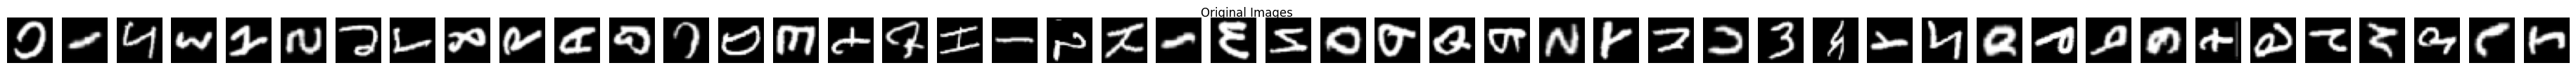

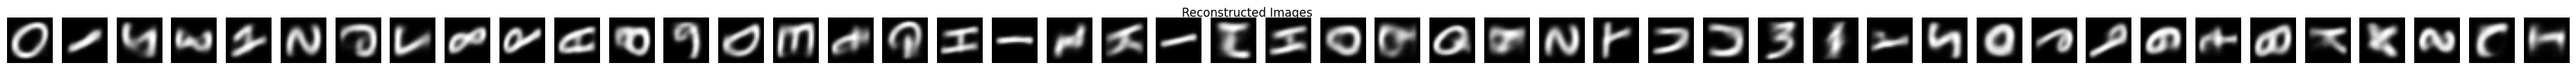

In [19]:
sample_and_reconstruct(dataset, encoder, decoder, input_dim=28*28, num_classes=47, temperature=final_temperature)

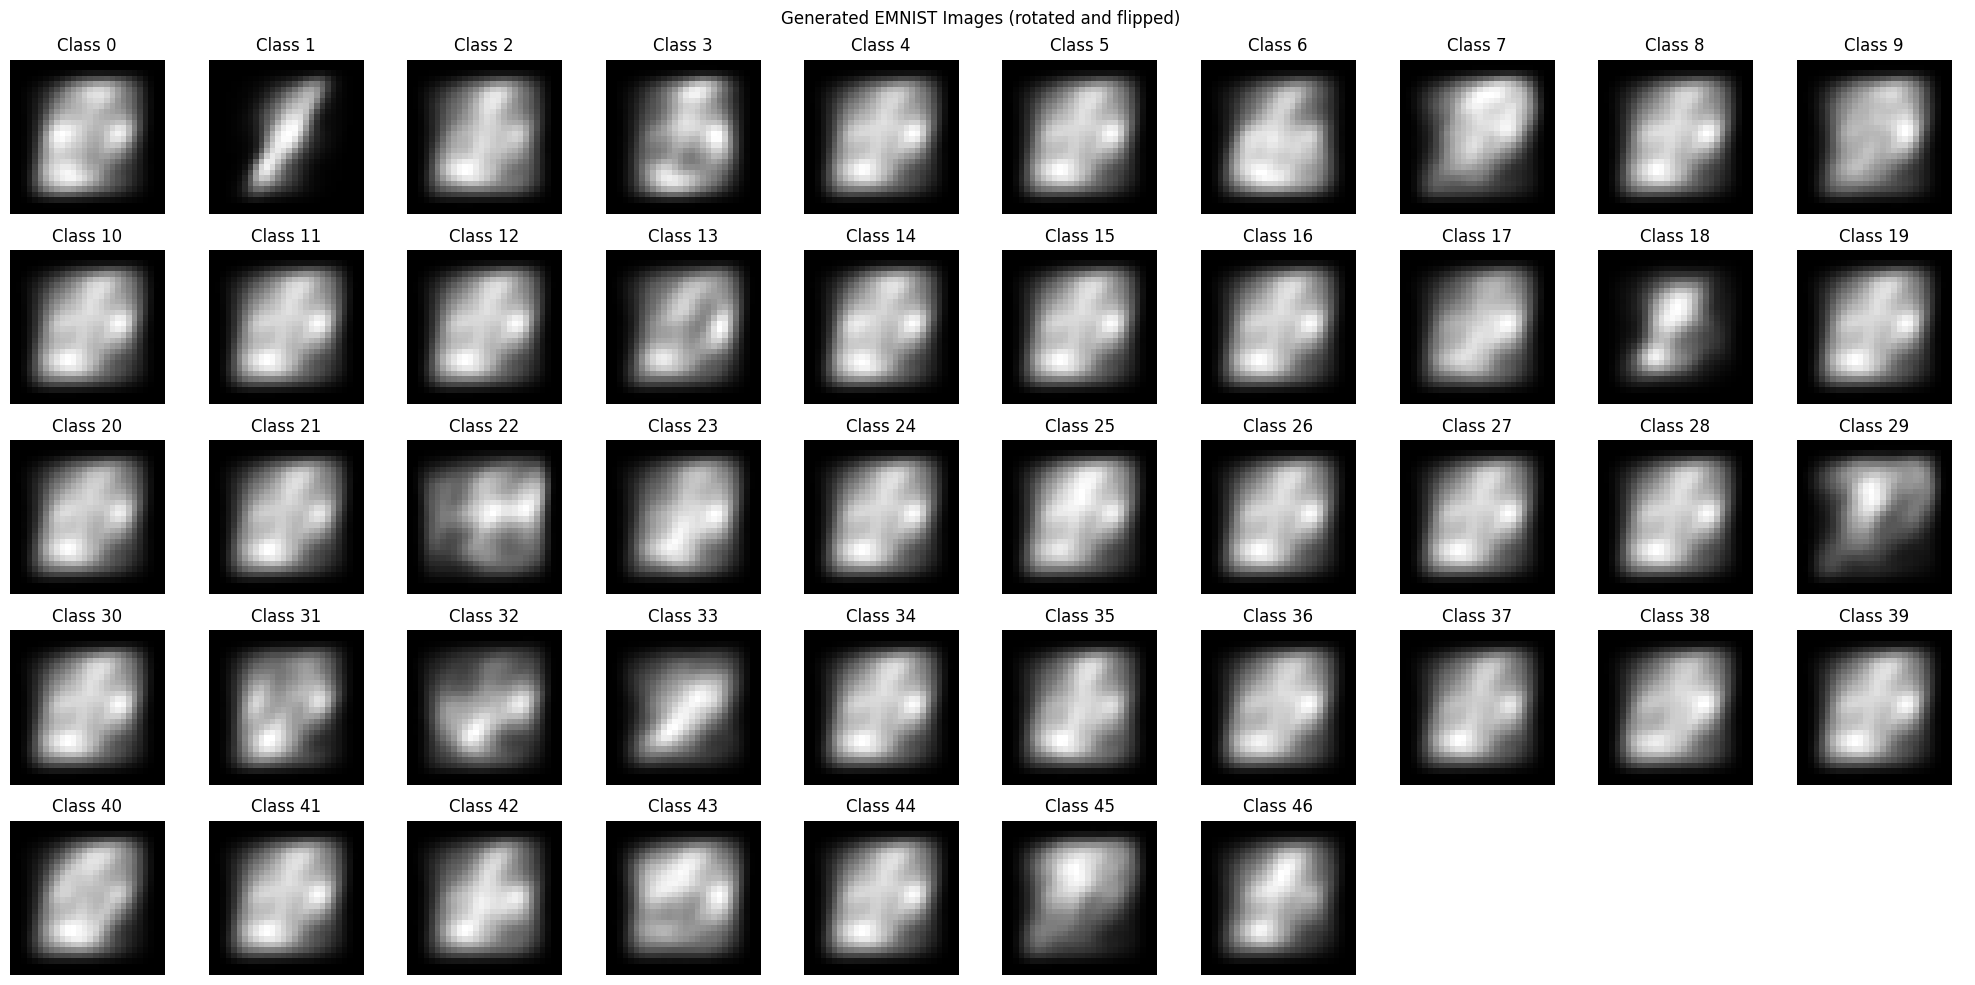

In [20]:
categorical_dim = 47
input_dim = 28 * 28
temperature = 0.5
generate_from_latent(dataset, encoder, decoder, categorical_dim=47, temperature=final_temperature)

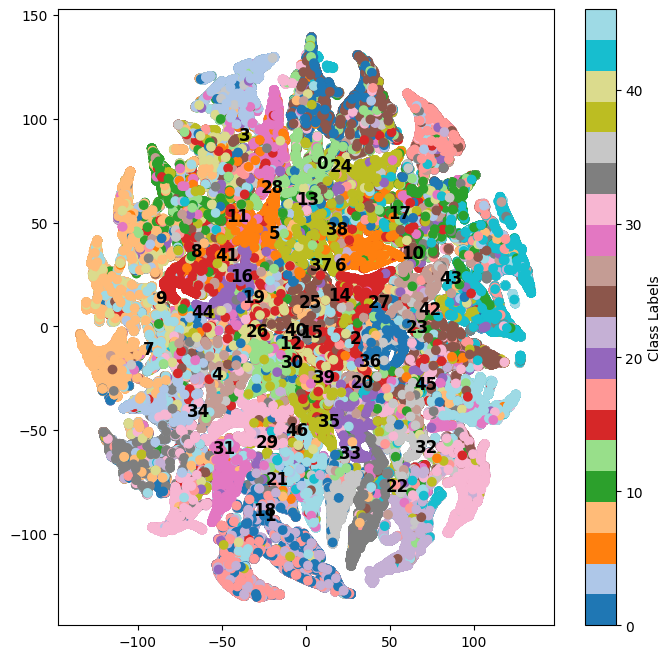

<Figure size 1000x800 with 0 Axes>

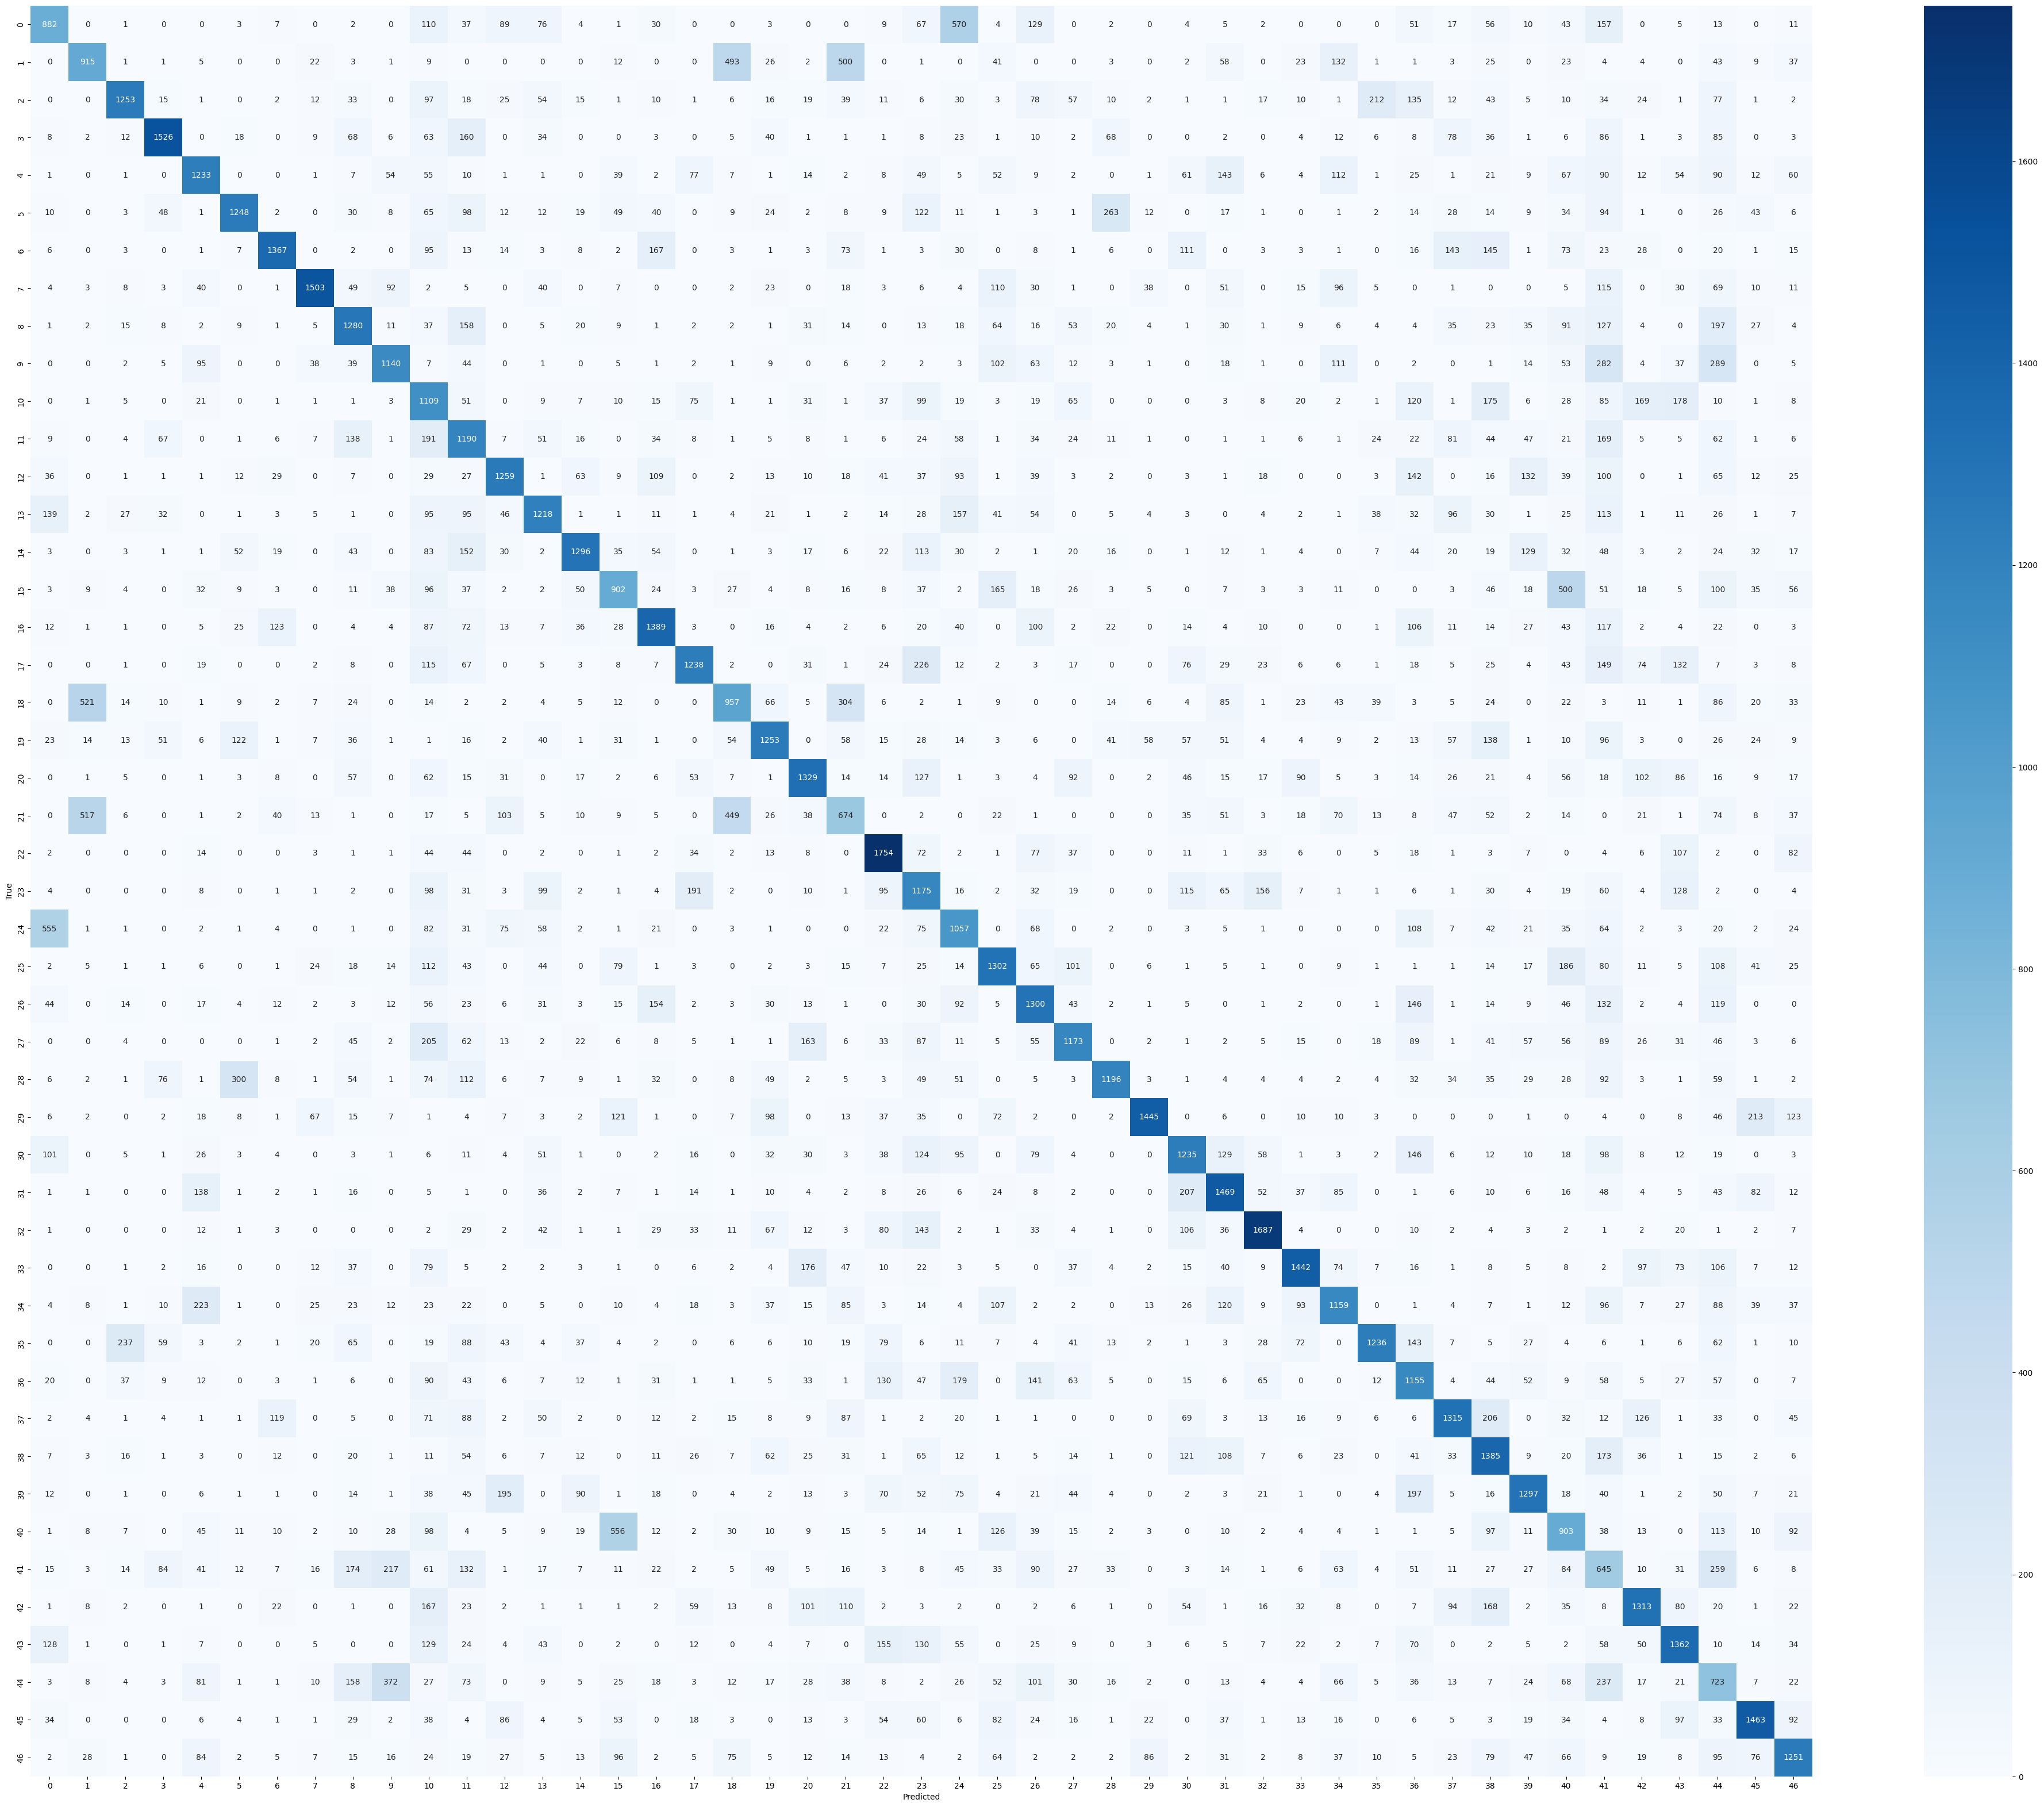

Rand index:  0.27182647789532083


In [21]:
visualize_latent(dataset_name, encoder, num_classes=47, temperature=final_temperature)